# Homework 4

In [2]:
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображенииа, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершут предобработку картинки, писанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер равномерно занимало место, то есть если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в приложении к этому занятию.

<table><tr>
    <td> <img src="https://i.ibb.co/fkScTsg/test_image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/q7PQRtZ/test_image_03.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/StTqhST/test_image_08.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [3]:
path = "whale_tail/test_image_"
whale_tails = []
for i in range(13):
    img = cv2.imread(path+str(i).zfill(2)+".jpg")
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    whale_tails += [img]

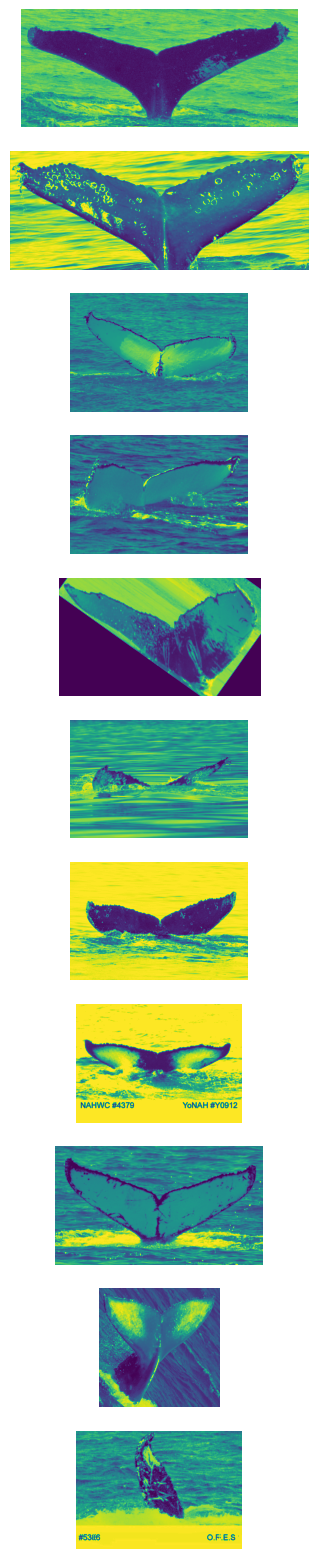

In [4]:
fig, ax = plt.subplots(len(whale_tails), 1, figsize=(len(whale_tails)*5, 20))

for i in range(len(whale_tails)):
    ax[i].imshow(whale_tails[i])
    ax[i].set_axis_off()

### Размышления о подходе
- Сразу скажу, что все изображения я `обрабатывал руками` 
- Поворачивать изображения я не стал. Объясняю это тем, что после сегментации, даже скрученные изображения выглядят как изображения сфотографированные в фас. 
- Принял решение постараться более аккуратно выделить сами хвосты. В наборе данных были совсем приятные изображеия, несколько кривоватых и два изображения, на которых хвост по цвету почти сливается с водой. 
- Мой подход целиком был завязан на изучении распределении цвета на изображении. Я брал гистограммы и принимал решение какие места занулять, а какие выделить. В нескольких изображениях получилось хорошо выделить границы, но не внутренности самих хвостов. В таких изображениях я старался путем нескольких размытий, открытий и других морфологических операций выделить +- хвост. 
- Процесс можно автоматизировать в случае изображений с двумя ярко выраженными модами или модой. Также изображения на которых есть широкий пик и небольшой пик, потенциально могут быть обработанны: оставляем только малый пик, в ожидании, что это будут границы хвостов, делаем серию морфологических операций, заливаем изображение внутри контура. Параметры для морфологических операций должны быть полученны на большем числе изображений, для лучшего преобразования большей части картинок.

### Obvious examples
Those are: 0, 1, 4, 6, 7, 8, 10

In [337]:
def obvious_pics_preproc(img, lower_bound=0, upper_bound=255, show_hist=False):
    tail = img
    if show_hist:
        plt.plot(cv2.calcHist([tail.ravel()], [0], None, [256], [0, 256]))
        plt.show()
    new_tail = tail.copy()
    new_tail[new_tail > upper_bound] = 0
    new_tail[new_tail < lower_bound] = 0
    new_tail[new_tail != 0] = 255
    plt.axis("off")
    plt.imshow(new_tail)

    return new_tail

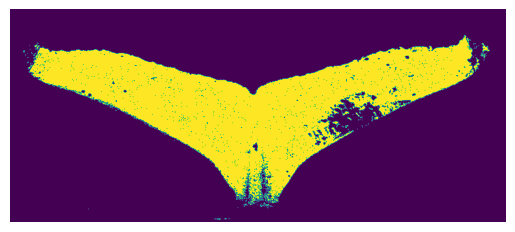

In [338]:
_ = obvious_pics_preproc(whale_tails[0], upper_bound=45)

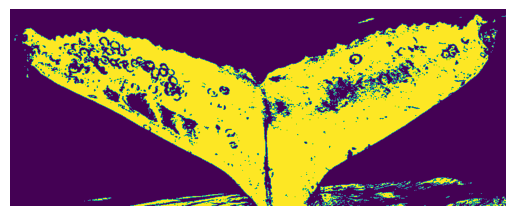

In [339]:
_ = obvious_pics_preproc(whale_tails[1], upper_bound=130)

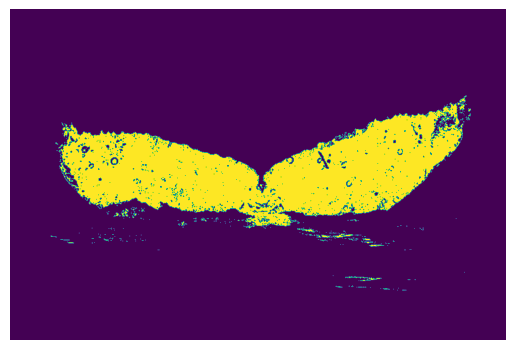

In [340]:
_ = obvious_pics_preproc(whale_tails[6], upper_bound=50)

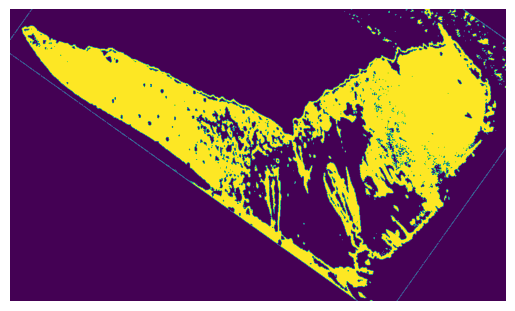

In [341]:
_ = obvious_pics_preproc(whale_tails[4], lower_bound=50, upper_bound=150)

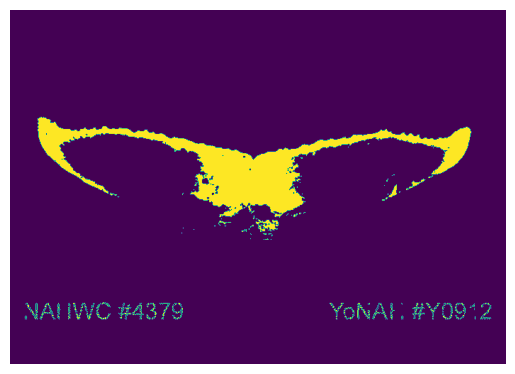

In [383]:
_ = obvious_pics_preproc(whale_tails[7], upper_bound=50)

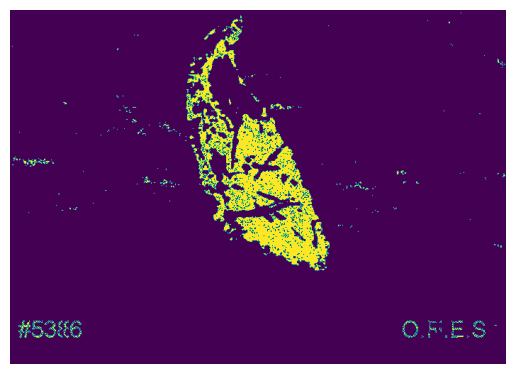

In [382]:
# На этом примере даже глазами плохо понимаю где тут хвост
_ = obvious_pics_preproc(whale_tails[10], upper_bound=50)

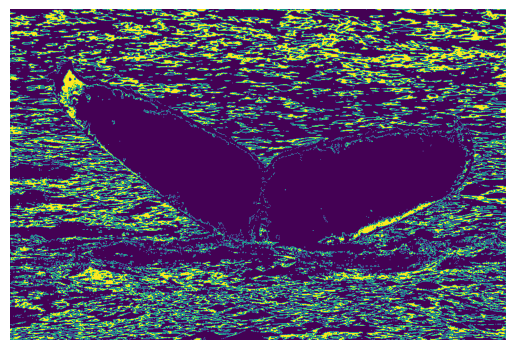

In [374]:
countor_8 = obvious_pics_preproc(whale_tails[2], lower_bound=100, upper_bound=120)

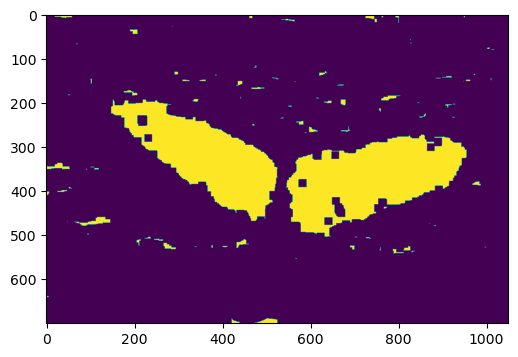

In [381]:
new_example = countor_8.copy()

new_example = cv2.GaussianBlur(new_example, ksize=(7, 7), sigmaX=15, sigmaY=15)
new_example = cv2.dilate(new_example, np.ones((7, 7)), iterations = 1)


ret, new_example = cv2.threshold(new_example, 0, 100, cv2.THRESH_BINARY_INV)
new_example = cv2.erode(new_example, np.ones((5, 5)), iterations = 1)
# new_example_hist = cv2.calcHist([new_example.ravel()], [0], None, [256], [0, 256])

plt.figure(figsize=(6, 4))
plt.imshow(new_example)

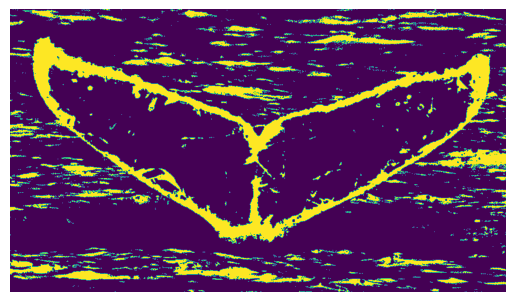

In [350]:
countor_2 = obvious_pics_preproc(whale_tails[8], upper_bound=85)

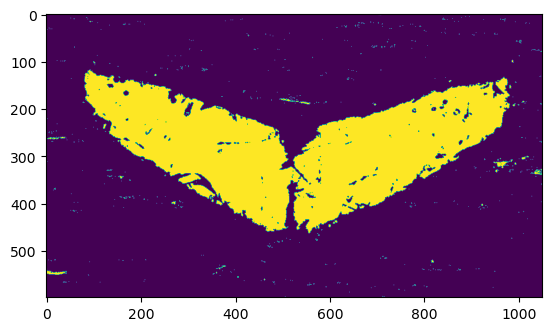

In [362]:
cnt = countor_2.copy()
h, w = cnt.shape
mask = np.zeros((h+2, w+2), np.uint8)
new_cnt = cv2.floodFill(cnt, mask, (h//2, w//2), (255))[1]
inv_cnt = np.zeros_like(new_cnt)
inv_cnt[new_cnt == 0] = 1
plt.imshow(inv_cnt)

### Not so obvious

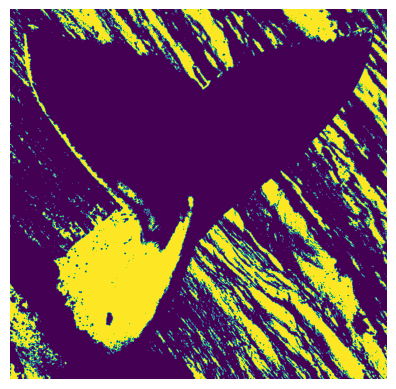

In [346]:
tail_9 = obvious_pics_preproc(whale_tails[9], lower_bound=0, upper_bound=50)

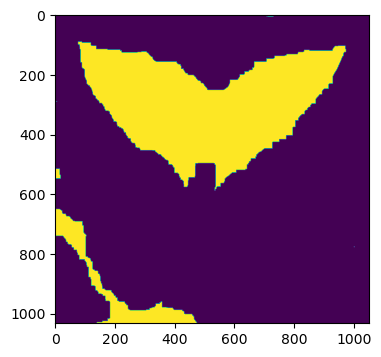

In [347]:
new_example = tail_9.copy()

new_example = cv2.GaussianBlur(new_example, ksize=(3, 3), sigmaX=15, sigmaY=15)
new_example = cv2.dilate(new_example, np.ones((7, 7)), iterations = 3)


ret, new_example = cv2.threshold(new_example, 0, 100, cv2.THRESH_BINARY_INV)
new_example = cv2.erode(new_example, np.ones((5, 5)), iterations = 8)
# new_example_hist = cv2.calcHist([new_example.ravel()], [0], None, [256], [0, 256])

plt.figure(figsize=(6, 4))
plt.imshow(new_example)


Ничего нормального не получилось с номерами: 3, 5

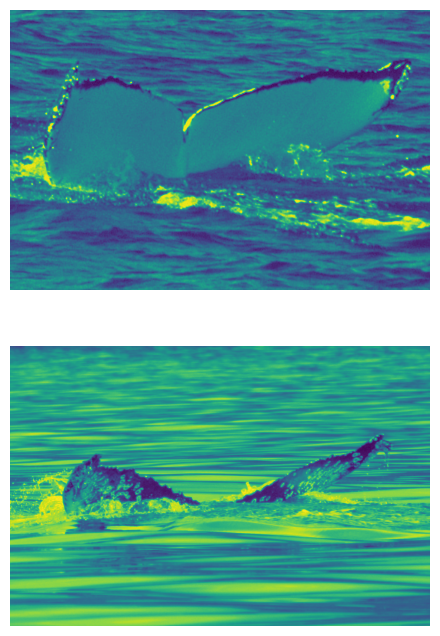

In [297]:
bad_examples = [3, 5]
fig, ax = plt.subplots(len(bad_examples), 1, figsize=(len(bad_examples)*5, 8))

for i, tail_num in enumerate(bad_examples):
    ax[i].imshow(whale_tails[tail_num])
    ax[i].set_axis_off()